In [2]:
source("/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/libraries_visuals.R")
source(("/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/libraries_analysis.R"))

Registered S3 methods overwritten by 'ggtern':
  method           from   
  grid.draw.ggplot ggplot2
  plot.ggplot      ggplot2
  print.ggplot     ggplot2

--
Remember to cite, run citation(package = 'ggtern') for further info.
--


Attaching package: ‘ggtern’


The following object is masked from ‘package:gghighlight’:

    aes


The following objects are masked from ‘package:ggplot2’:

    aes, annotate, ggplot, ggplot_build, ggplot_gtable, ggplotGrob,
    ggsave, layer_data, theme_bw, theme_classic, theme_dark,
    theme_gray, theme_light, theme_linedraw, theme_minimal, theme_void


Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal


corrplot 0.92 loaded


Attaching package: ‘corrplot’


The following object is masked from ‘package:arm’:

    corrplot


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘patchwork’


The following object is ma

### Visualisation of Conditional haplotype analysis

In [3]:
smallest_number <- .Machine$double.xmin

#phenotype <- 'I'
#hla_gene <- 'DQA1'
n_rounds <- 4

first <- TRUE
for (phenotype in c('I', 'H', 'Both')){
    for (hla_gene in c('DQA1', 'DQB1', 'DRB1')){
        if (phenotype == 'Both'){
            path_to_phenotype <- '/with_groups/both/'
        } else {
            path_to_phenotype <- paste0(phenotype,'/')
        }

        n_tests <- 0
        for (i in seq(1,n_rounds)){
            file_path <- paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/conditional_analysis/',path_to_phenotype,hla_gene,'_conditional_round_',i,'.tsv')
            n_df <- nrow(fread(file_path))
            n_tests <- n_tests + n_df/2
        }

        file_path <- paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/conditional_analysis/',path_to_phenotype,hla_gene,'_conditional_round_',n_rounds,'.tsv')
        df <- na.omit(fread(file_path)) %>% 
            filter(Pvalue <= 0.05/n_tests) %>%
            group_by(Length_cdr3) %>% 
            unique() %>%
            filter(Pvalue == min(Pvalue)) %>%
            filter(Omnibus == max(Omnibus))%>%
            ungroup() %>%
            dplyr::select(Length_cdr3, Pvalue, IMGT, Omnibus, condition) %>%
            rename('variance_explained' = 'Omnibus') %>%
            mutate(cond_round = n_rounds, phenotype = phenotype, hla_gene = hla_gene)
        if (first){
            df_all <- df
            first <- FALSE
        } else {
            df_all <- rbind(df_all, df)
        }

}}



In [29]:
df_with_sites <- df_all %>% filter(Length_cdr3 %in% c('L13', 'L15')) %>% separate_rows(condition, sep = '_') %>% group_by(Length_cdr3, phenotype, hla_gene)  %>%
    mutate(cond_round = seq(1, n())) %>% ungroup() %>% dplyr::select(c(hla_gene, phenotype, condition)) %>% unique()

In [54]:
df_combined <- na.omit(fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/manova_results/main_manova_as_in_Ishigaki.tsv')[, 
                Length_cdr3 := paste0('L', Length_cdr3)][HLA %in% c('DQA1', 'DQB1', 'DRB1')]) %>% 
                rename('Pvalue' = 'Pr(>F)') %>% 
                group_by(HLA) %>% unique() %>% 
                filter(Pvalue == min(Pvalue)) %>% 
                filter(variance_explained == max(variance_explained))%>%
                mutate(Dataset = 'Both', cond_round = 0) %>%
                ungroup() %>%
                dplyr::select(HLA, Dataset, Pvalue, variance_explained, Site_hla, cond_round) %>% group_by(HLA, Site_hla) %>% 
                mutate(variance_explained = max(variance_explained), Pvalue = min(Pvalue)) %>% ungroup() %>% unique()


df_healthy <- na.omit(fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/HEALTHY/manova_results_wo_correlation_in_PCA.tsv'))
df_healthy <- df_healthy[,
    c('HLA', 'Site_hla', 'Length_cdr3', 'IMGT'):= tstrsplit(pair,':')][, 
    Length_cdr3 := paste0('L', Length_cdr3)][HLA %in% c('DQA1', 'DQB1', 'DRB1')] %>% 
    rename('Pvalue' = grep('Pr', names(df_healthy), value = TRUE)) %>% 
    group_by(HLA) %>% unique() %>% 
    filter(Pvalue == min(Pvalue)) %>% 
    filter(variance_explained == max(variance_explained))%>%
    mutate(Dataset = 'Healthy', cond_round = 0) %>%
    ungroup() %>%
    dplyr::select(HLA, Dataset, Pvalue, variance_explained, Site_hla, cond_round) %>% group_by(HLA, Site_hla) %>% 
    mutate(variance_explained = max(variance_explained), Pvalue = min(Pvalue)) %>% ungroup() %>% unique()

df_ibd <- na.omit(fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/IBD/manova_results_downsampled_wo_correlation_in_alleles_using_3_PCs.tsv'))
df_ibd <- df_ibd[,
    c('HLA', 'Site_hla', 'Length_cdr3', 'IMGT'):= tstrsplit(pair,':')][, 
    Length_cdr3 := paste0('L', Length_cdr3)][HLA %in% c('DQA1', 'DQB1', 'DRB1')] %>% 
    rename('Pvalue' = grep('Pr', names(df_ibd), value = TRUE)) %>% 
    group_by(HLA) %>% unique() %>% 
    filter(Pvalue == min(Pvalue)) %>% 
    filter(variance_explained == max(variance_explained))%>%
    mutate(Dataset = 'IBD', cond_round = 0) %>%
    ungroup() %>%
    dplyr::select(HLA, Dataset, Pvalue, variance_explained, Site_hla, cond_round) %>% group_by(HLA, Site_hla) %>% 
    mutate(variance_explained = max(variance_explained), Pvalue = min(Pvalue)) %>% ungroup() %>% unique()

df_combined <- rbind(df_combined, df_healthy, df_ibd)

In [47]:
df_combined

HLA,Dataset,Pvalue,variance_explained,Site_hla,cond_round
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
DQA1,Both,0.000000e+00,0.08196969,47,1
DQB1,Both,0.000000e+00,0.07229775,125,1
DRB1,Both,0.000000e+00,0.12384417,13,1
DRB1,Healthy,5.102422e-300,0.14613361,13,1
DQA1,Healthy,1.815313e-191,0.07853153,47,1
DQB1,Healthy,3.434916e-211,0.08009367,125,1
DQA1,IBD,1.374017e-153,0.07173901,47,1
DQB1,IBD,5.015347e-171,0.06633111,87,1
DRB1,IBD,9.329753e-243,0.11753613,13,1


In [125]:
first <- TRUE
n_rounds <- 4
phenotype <- 'H'
for (hla_gene in c('DRB1', 'DQA1', 'DQB1')){
    for (i in seq(1,n_rounds)){
        file_path <- paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/conditional_analysis/',phenotype,'/',hla_gene,'_conditional_round_',i,'.tsv')
        df_rounds <- na.omit(fread(file_path)) %>% 
            filter(Pvalue <= 0.05/n_tests) %>%
            filter(Length_cdr3 %in% c('L13', 'L15')) %>%
            filter(Pvalue == min(Pvalue)) %>%
            ungroup() %>%
            dplyr::select(Pvalue, Omnibus, condition) %>% 
            rename('variance_explained' = 'Omnibus', 'Site_hla' = 'condition') %>%
            separate_rows(Site_hla, sep = '_') %>% unique() %>%
            mutate(cond_round = seq(0,n()-1), Dataset = ifelse(phenotype == 'I', 'IBD', 'Healthy'), HLA = hla_gene) %>% filter(cond_round == i) %>% unique()
        if (first){
            df_rounds_all <- df_rounds
            first <- FALSE
        } else {
            df_rounds_all <- rbind(df_rounds_all, df_rounds)
        }
    }
}

In [126]:
df_rounds_all

Pvalue,variance_explained,Site_hla,cond_round,Dataset,HLA
<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>
4.723846e-114,0.1870452,71,1,Healthy,DRB1
4.404713e-60,0.2018978,37,2,Healthy,DRB1
1.055907e-27,0.2326587,86,3,Healthy,DRB1
8.179311e-07,0.1839139,67,4,Healthy,DRB1
6.598284e-102,0.1350605,41,1,Healthy,DQA1
1.515303e-46,0.1711387,34,2,Healthy,DQA1
1.460570e-37,0.1803626,107,3,Healthy,DQA1
1.091696e-07,0.1771812,25,4,Healthy,DQA1
4.032710e-99,0.1449164,74,1,Healthy,DQB1


In [102]:
df_combined_all <- rbind(df_combined_all, df_rounds_all)

In [144]:
df_combined_all <- df_combined_all %>% mutate(Site_hla = as.numeric(Site_hla), Pvalue = ifelse(Pvalue == 0, smallest_number, Pvalue))

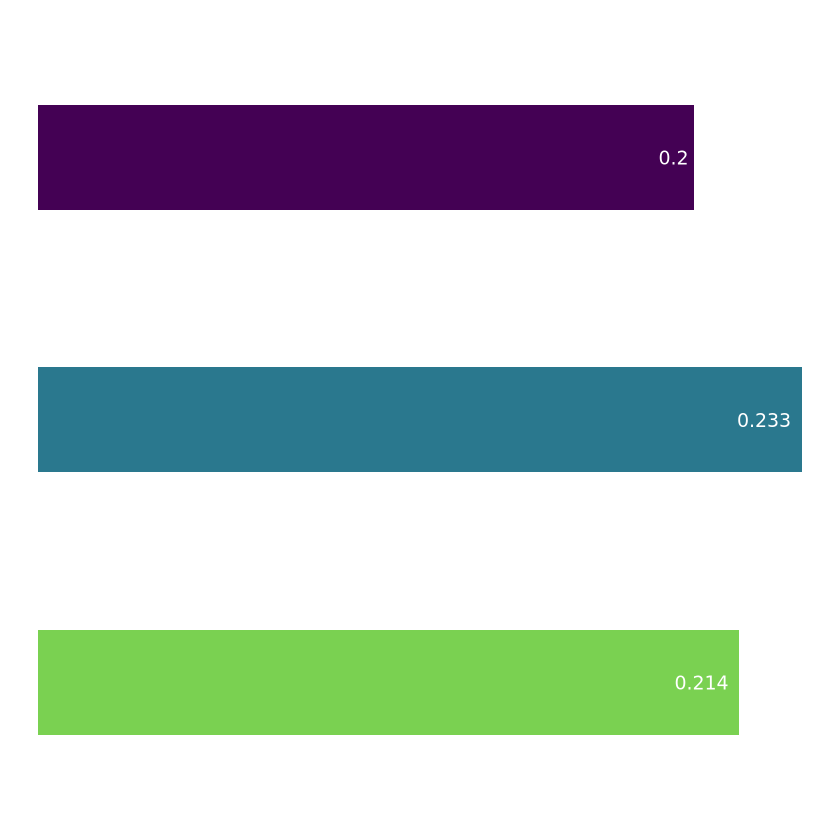

In [142]:
df_var <- df_combined_all %>% group_by(HLA, Dataset) %>% mutate(max_var = max(variance_explained)) %>%
    dplyr::select(Dataset, HLA, max_var) %>% 
    unique()

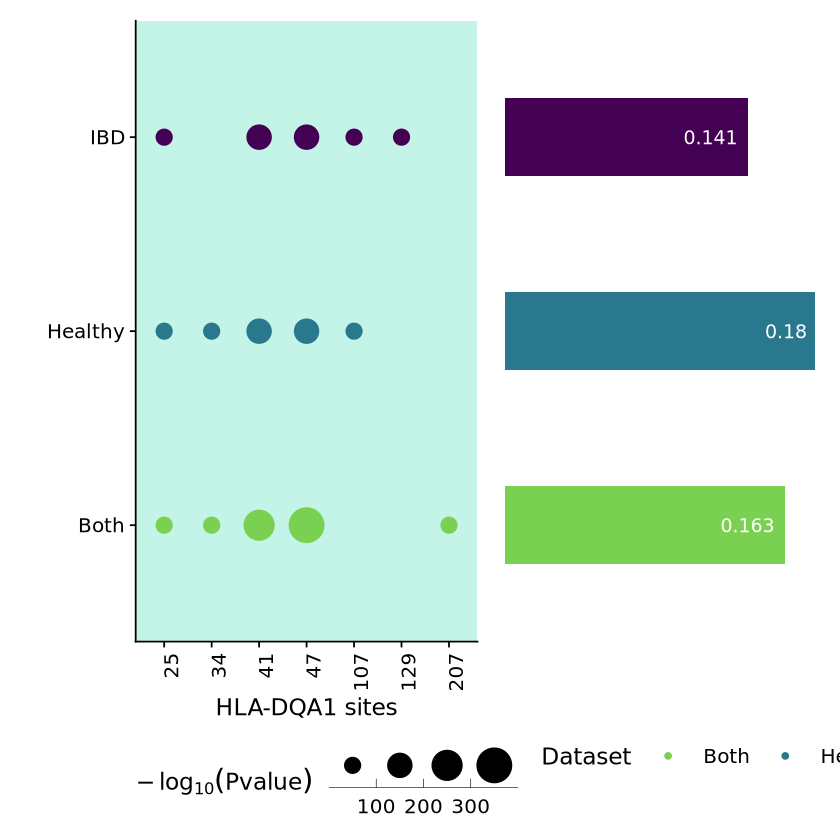

In [151]:
pl_var <- ggplot(data = df_var %>% filter(HLA == 'DQA1'), aes(x = max_var, y = Dataset, fill = Dataset)) +
    geom_col(width = 0.4, show.legend = FALSE) +
    geom_text(aes(label = round(max_var, 3)), color = "white", size = 4, hjust = 1.2, show.legend = FALSE) +
    scale_fill_viridis_d(begin = 0, end = 0.8, direction = -1) +
    theme_void()

pl_dots <- ggplot(df_combined_all %>% filter(HLA == 'DQA1'), aes(x = factor(Site_hla), y = Dataset, size = -log10(Pvalue))) + 
    scale_size_binned(n.breaks = 5, range = c(1, 10)) +
    geom_point(aes(color = Dataset)) +
    scale_color_viridis_d(end = 0.8, direction = -1) +
    theme_cowplot() +
    labs(x = paste0('HLA-DQA1 sites'), y = ' ', size = expression(-log[10](Pvalue))) +
    theme(legend.box = "horizontal", legend.position = "bottom", legend.key.width = unit(1, "cm"),
        panel.background = element_rect(fill = "#c4f3e7"), axis.text.x = element_text(angle = 90, hjust = 1))

pl_both <- pl_dots +  pl_var
pl_both


In [152]:
ggsave(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/CDR3_QTLs_DQA1_datasets.png'), 
    pl_both, width = 9, height = 7)

In [35]:
pl <- ggplot(df_combined_all, aes(x = factor(Site_hla), y = phenotype, size = Pvalue)) + 
    geom_point() + 
    facet_wrap(~ Length_cdr3 +  hla_gene, scales = 'free', ncol = 3) + 
    scale_color_viridis_d(end = 0.8) + 
    theme_minimal() + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
    labs(x = 'CDR3-QTLs - HLA sites that influence CDR3 composition', y = 'Datasets', size = 'Variance explained', color = 'Phenotype') + 
    scale_size_continuous(range = c(1,10)) + 
    theme(legend.position = 'bottom') 
ggsave('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/conditional_analysis_round_4.png', pl, width = 10, height = 30,)

### Visualise GWAS HLA sites in UC and CD

In [ ]:
library(readxl)

#### DRB1

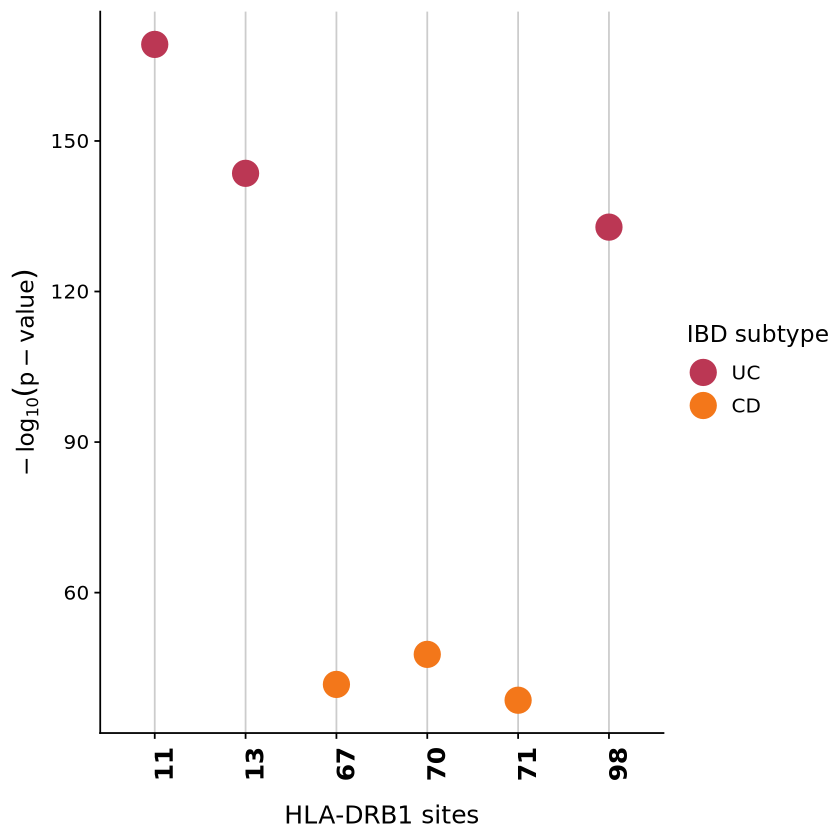

In [175]:
hla_gene <- 'DRB1'
goyette_uc <- as.data.table(read_excel(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/UC_',hla_gene,'.xlsx')))
goyette_uc[, subtype := 'UC'][, AA_Position := as.numeric(AA_Position)]
goyette_cd <- as.data.table(read_excel(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/CD_',hla_gene,'.xlsx')))
goyette_cd[, subtype := 'CD'][, AA_Position := as.numeric(AA_Position)]
goyette <- rbind(goyette_uc, goyette_cd)#[, AA_Position := as.numeric(AA_Position)]

goyette_sites <- goyette %>% 
    dplyr::select(AA_Position, p_value_site, subtype) %>% 
    na.omit() %>%
    group_by(subtype) %>%
    arrange(p_value_site) %>% 
    slice(1:3) %>%
    arrange(AA_Position)
ggplot(goyette_sites, aes(x = as.factor(AA_Position), y = -log10(p_value_site), color = subtype)) + 
    geom_point( size = 7) + 
    scale_color_viridis_d(option = 'inferno', end = 0.5, begin = 0.7, breaks = c("UC", "CD")) + 
    theme_cowplot() +
    labs(x = paste0('HLA-',hla_gene,' sites'), 
        y = expression(-log[10](p-value)), 
        color = 'IBD subtype') +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, face = 'bold', margin = margin(t = 5), size = 15),
        axis.title.x = element_text( margin = margin(t = 15), size = 15),
        panel.grid.major.y = element_blank(),
        panel.grid.minor.y = element_blank(),
        panel.grid.major.x = element_line(color = "gray80"),
        panel.grid.minor.x = element_line(color = "gray80"))

In [117]:
goyette %>% 
    dplyr::select(AA_Position, p_value_site, subtype) %>% 
    na.omit() %>%
    group_by(subtype) %>%
    arrange(p_value_site) %>% slice(1:10) %>%
    arrange(AA_Position)

AA_Position,p_value_site,subtype
<dbl>,<dbl>,<chr>
11,6.739120e-15,CD
11,5.824644e-170,UC
13,8.040185e-27,CD
13,2.836126e-144,UC
16,1.202230e-13,CD
30,6.030414e-86,UC
37,5.681141e-118,UC
57,1.060962e-28,CD
60,2.169662e-14,CD


#### CD

In [ ]:
subtype <- 'CD'
hla_gene <- 'DRB1'
goyette <- read_excel(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/',subtype,'_',hla_gene,'.xlsx'))
goyette_sites <- as.data.table(na.omit(goyette[-1,1:4]))[, AA_Position := as.numeric(AA_Position)] %>% arrange(AA_Position) %>% unique()
ggplot(goyette_sites %>% filter(p_value_site < 1e-5), aes(x = as.factor(AA_Position), y = -log10(p_value_site))) + 
    geom_point() + 
    theme_minimal() +
    labs(x = paste0('HLA-',hla_gene,' sites'), y = expression(-log[10](p-value))) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

Warning message in file(con, "rb"):
“'raw = FALSE' but '/work_beegfs/sukmb667/projects/cdr3-qtl/' is not a regular file”
Warning message in file(con, "rb"):
“cannot open file '/work_beegfs/sukmb667/projects/cdr3-qtl/': it is a directory”


ERROR: Error in file(con, "rb"): cannot open the connection


### Check residues plot to check if later sites really improve the model

In [512]:
significant_hits <- c('47', '34', '129')
hla_reduced <- sites_recategorate(hla_alleles_patients, site_matrix(significant_hits))
hla_reduced_with_pca <- merge(hla_reduced, pca_dt, by = 'patient_id')
x_reduced_alleles <- colnames(hla_reduced)[-1]

site_comb <- site_matrix(c('47', '34', '129', '107'))
conditional_matrix <- sites_recategorate(hla_alleles_patients, site_comb)
cond_covariates <- colnames(conditional_matrix)[-1]

cdr3_matrix <- merge(cdr3_freq_split_length_wide[['L13']][['P109']], hla_reduced_with_pca, by = 'patient_id')
test <- merge(cdr3_matrix, conditional_matrix, by = 'patient_id')



In [513]:
cdr3_hla_matrix <- test
x_reduced_sites <- x_reduced_sites
conditional_sites <- cond_covariates

In [527]:
name_pair <- unique(cdr3_hla_matrix$pair)
n_pcs <- 3 #  change when needed
amino_acids <-c('A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y') 
Y_matrix <- as.matrix(cdr3_hla_matrix %>% dplyr::select(any_of(amino_acids)))
Y <- paste0('cbind(', paste(colnames(Y_matrix), collapse = ','),") ~")
x_reduced <- paste(x_reduced_sites, collapse = '+')
pcs <- paste0('PC', seq(1,n_pcs), collapse = '+')

comb_sites <- paste(conditional_sites, collapse = '+')

X_full <- paste(comb_sites, pcs, sep = '+')
X_null <- paste(x_reduced, pcs, sep = '+')


formula_full <- as.formula(str_c(Y, X_full))
formula_null <- as.formula(str_c(Y, X_null))
mod1 <- lm(formula_full, data = cdr3_hla_matrix)
mod0 <- lm(formula_null, data = cdr3_hla_matrix)
anova(mod1, mod0)

,Res.Df,Df,Gen.var.,Pillai,approx F,num Df,den Df,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1132,NA,0.5910840,NA,NA,NA,NA,NA
2,1133,1,0.5964405,0.1797022,12.19122,20,1113,4.299547e-36


In [485]:
file_path <- paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/conditional_analysis/',path_to_phenotype,hla_gene,'_conditional_round_3.tsv')
na.omit(fread(file_path)) %>%  group_by(Length_cdr3) %>% filter(Omnibus == max(Omnibus)) %>% unique() %>% define_cond_hits()

$L12
[1] "47"  "41"  "34"  "156"

$L12
[1] "47"  "41"  "34"  "161"

$L12
[1] "47"  "41"  "34"  "163"

$L12
[1] "47"  "41"  "34"  "175"

$L12
[1] "47" "41" "34" "75"

$L13
[1] "47"  "34"  "129" "107"

$L13
[1] "47"  "34"  "129" "69" 

$L14
[1] "47"  "129" "34"  "107"

$L14
[1] "47"  "129" "34"  "69" 

$L15
[1] "47"  "41"  "156" "34" 

$L16
[1] "47"  "129" "107" "34" 

$L17
[1] "47"  "129" "156" "25" 

$L18
[1] "47"  "129" "107" "34"

In [21]:
hla_matrix_ibd <- fread('../IBD/cdr3_hla_pairs_downsampled_wo_correlation_in_alleles_using_9_PCs/DQA1:54:13:P109_matrix.tsv')
hla_matrix_hlh <- fread('../HEALTHY//cdr3_hla_pairs_wo_correlation_in_alleles_using_9_PCs/DQA1:54:13:P109_matrix.tsv')
#hla_matrix[, dataset := ifelse(grepl("H", patient_id), 'healthy', 'IBD')]

In [20]:
hla_matrix_ibd %>% dplyr::select(allele_L) %>% table()

allele_L
  0   1   2 
573 168  19 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


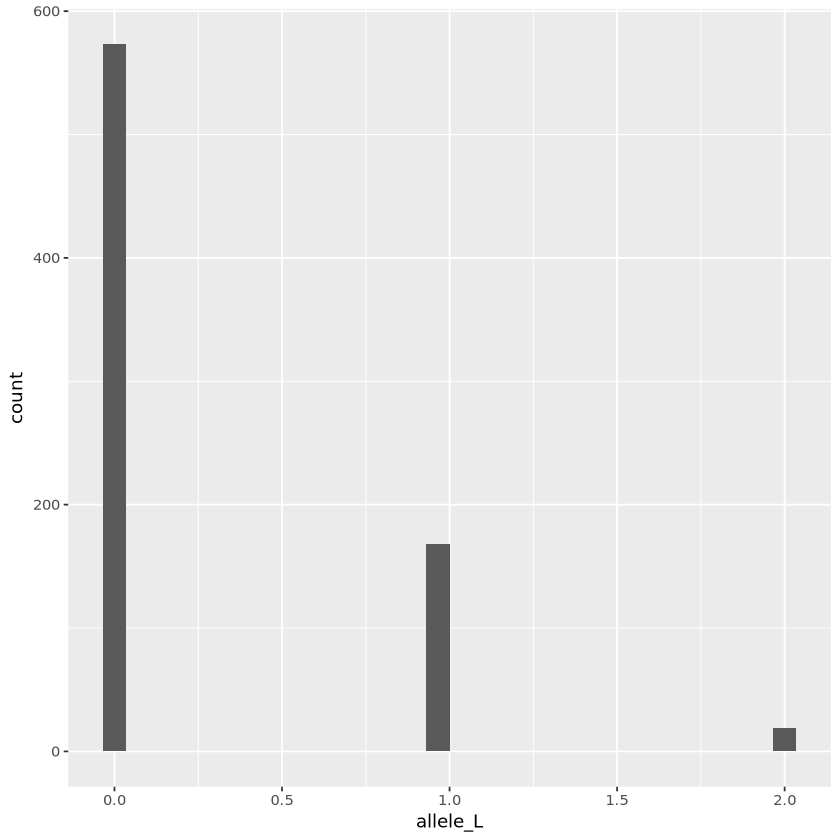

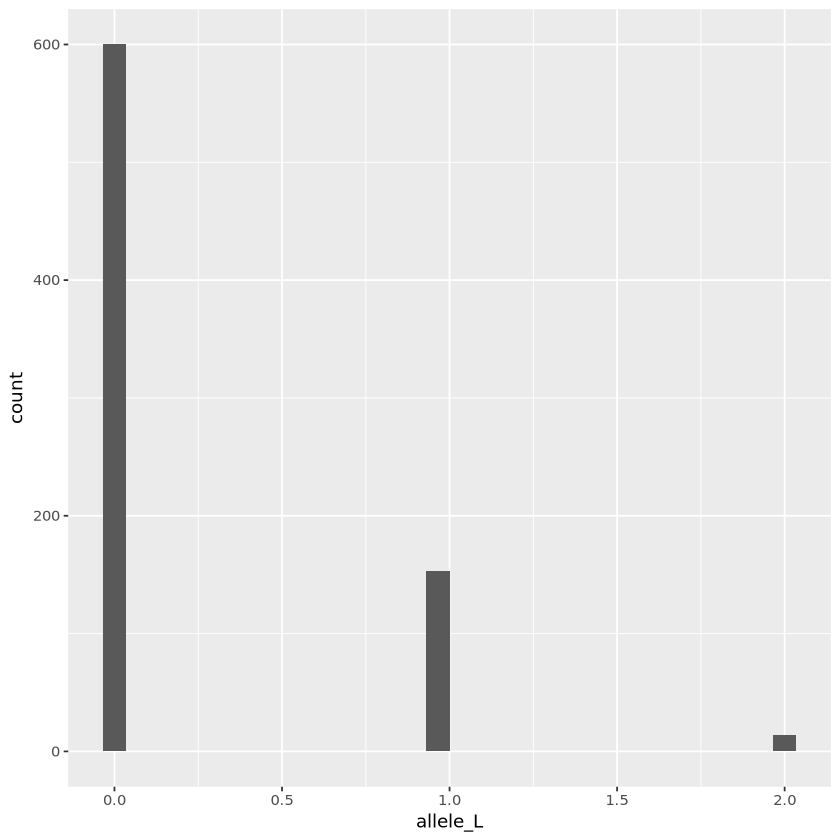

In [24]:
ggplot() +
geom_histogram(data = hla_matrix_ibd, aes(allele_L)) 

ggplot() + 
geom_histogram(data = hla_matrix_hlh, aes(allele_L) )

## Manhattan plot comparing our results and Ishigaki and Heatmap with variance explained 

In [5]:
manova_df_all <- read.csv('../../manova_results_9PCs.tsv', sep = '\t') %>% separate(pair, into = c('gene', 'site', 'length', 'position'), sep = ':', remove = FALSE)
n_tests <- 21000
bonf <- 0.01/n_tests

significant <- manova_df_all %>% filter(Pr..F. <= bonf) %>% arrange(Pr..F.)


In [39]:
manova_df_all %>% arrange(desc(variance_explained)) %>% filter(gene == 'A', site == 105, position == 'P107')

Res.Df,Df,Gen.var.,Pillai,approx.F,num.Df,den.Df,Pr..F.,pair,gene,site,length,position,Omnibus,model,P_val,variance_explained
<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
1887,NA,0.7998342,NA,NA,NA,NA,NA,A:105:12:P107,A,105,12,P107,0.03137624,null,0,0.0015353832
1888,1,0.8006578,0.030700916,2.9582877,20,1868,1.200481e-05,A:105:12:P107,A,105,12,P107,0.03291163,full,0,0.0015353832
1887,NA,0.7593124,NA,NA,NA,NA,NA,A:105:14:P107,A,105,14,P107,0.03673827,null,0,0.0011589564
1888,1,0.7597434,0.021706275,2.0723491,20,1868,3.520597e-03,A:105:14:P107,A,105,14,P107,0.03789723,full,0,0.0011589564
1887,NA,0.7562986,NA,NA,NA,NA,NA,A:105:13:P107,A,105,13,P107,0.04353671,null,0,0.0010597198
1888,1,0.7566616,0.019991192,1.9052658,20,1868,9.100003e-03,A:105:13:P107,A,105,13,P107,0.04459643,full,0,0.0010597198
1887,NA,0.7682277,NA,NA,NA,NA,NA,A:105:15:P107,A,105,15,P107,0.04226951,null,0,0.0010077384
1888,1,0.7685647,0.019182519,1.8266877,20,1868,1.396744e-02,A:105:15:P107,A,105,15,P107,0.04327725,full,0,0.0010077384
1887,NA,0.8702225,NA,NA,NA,NA,NA,A:105:17:P107,A,105,17,P107,0.01597752,null,0,0.0006151492


In [37]:
manova_variance <- manova_df_all %>%
    filter(model == 'full') %>%
    dplyr::select(pair, Pr..F., gene, site, position, P_val, variance_explained) %>% 
    group_by(gene, site, position) %>% 
    reframe(var_explained_max = max(variance_explained),
           P_val = P_val[variance_explained == max(variance_explained)]) %>% 
    mutate(site = factor(as.numeric(site)), significance = ifelse(P_val >= 0.05, 'non_sig', 'sig'),
          var_explained_to_plot = ifelse(significance == 'sig', var_explained_max, NA))
manova_variance 

gene,site,position,var_explained_max,P_val,significance,var_explained_to_plot
<chr>,<fct>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
A,105,P106,0.0085008124,7.576517e-01,non_sig,NA
A,105,P107,0.0015353832,0.000000e+00,sig,0.0015353832
A,105,P108,0.0014945024,0.000000e+00,sig,0.0014945024
A,105,P109,0.0034512037,0.000000e+00,sig,0.0034512037
A,105,P110,0.0030538676,0.000000e+00,sig,0.0030538676
A,105,P111,0.0022203954,0.000000e+00,sig,0.0022203954
A,105,P111.1,0.0009715285,0.000000e+00,sig,0.0009715285
A,105,P112,0.0026131879,0.000000e+00,sig,0.0026131879
A,105,P112.1,0.0019947543,0.000000e+00,sig,0.0019947543


In [87]:
hla_gene_variance <- manova_variance %>%
    group_by(gene, site) %>% 
    summarise(total_var_explained = sum(var_explained_max), .groups = 'keep') %>%
    ungroup()

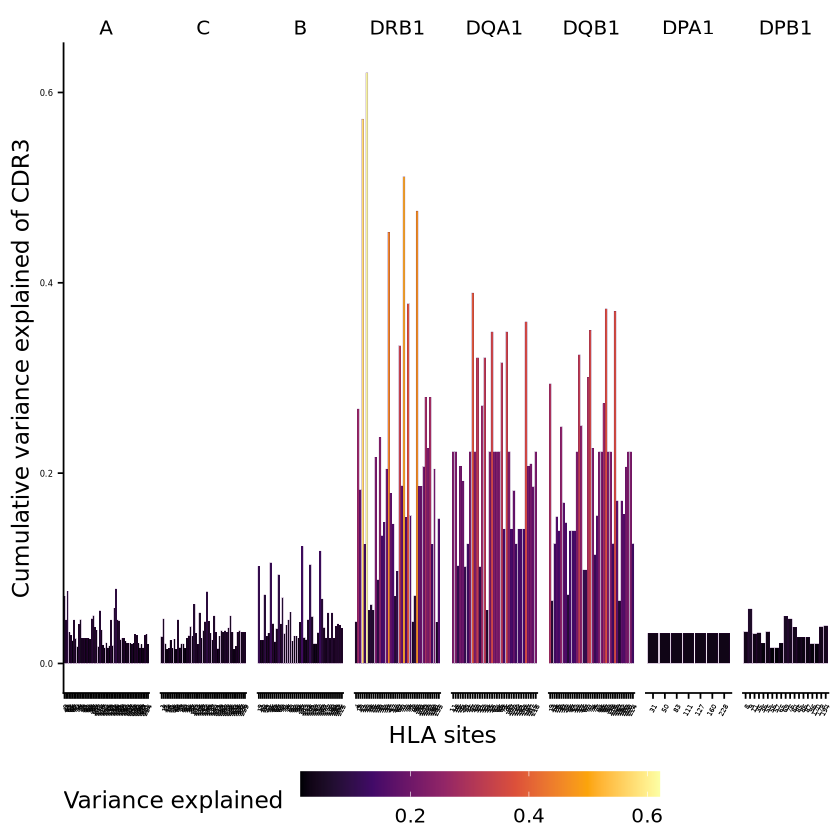

In [132]:
col_plot_var <- ggplot() +
    geom_col(data = hla_gene_variance, aes(x = site, y = total_var_explained, fill = total_var_explained ), color = "#440154", linewidth = 0.06)+
    scale_fill_viridis_c(na.value = 'white', option = 'inferno') +
    labs( x = "HLA sites ", y = "Cumulative variance explained of CDR3", fill = 'Variance explained') +
    theme_cowplot() +
    facet_wrap(~factor(gene, levels = hla_genes), scales = 'free_x', nrow = 1) +
    theme(legend.position = 'bottom',  
        axis.text.x = element_text(size = 4, angle = 60, hjust = 1),
        axis.text.y = element_text(size = 5),
        strip.background = element_rect(fill = "white")) +
    guides(fill=guide_colourbar(barwidth=15))
col_plot_var
ggsave('../../plots/col_plot_variance_explained.png',col_plot_var, width = 20, height = 7)

### Heapmap with variance explained

In [39]:
sites <- sort(unique(pull(drb1_variance, site)))
sites

[1] "10"  "104" "11"  "112" "12"  "120" "13"  "133" "14"  "140" "142" "149"
[13] "16"  "180" "181" "189" "233" "25"  "26"  "28"  "30"  "31"  "32"  "33" 
[25] "37"  "38"  "4"   "47"  "57"  "58"  "60"  "67"  "70"  "71"  "73"  "74" 
[37] "77"  "78"  "85"  "86"  "9"   "96"  "98"

In [14]:
hla_genes = c('A','C','B','DRB1','DQA1', 'DQB1', 'DPA1','DPB1')

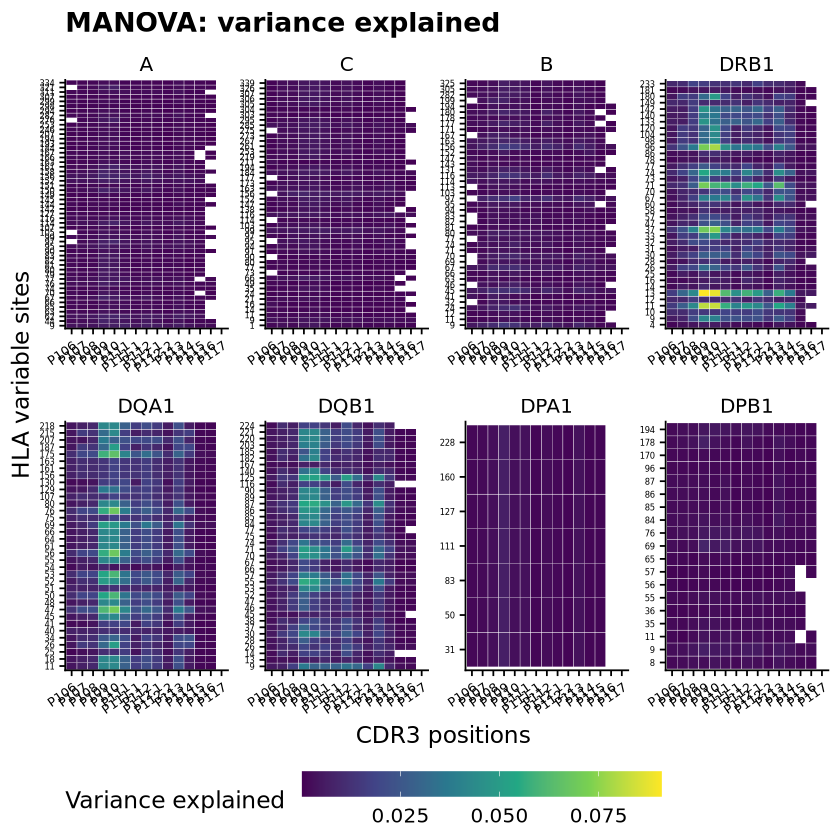

In [43]:
heatmap_plot <- ggplot(manova_variance, aes(x = position, y = site, fill = var_explained_to_plot)) +
  geom_tile(color = 'white', linetype = 1) +
  scale_fill_viridis_c(na.value = 'white') +
  theme_cowplot() +
  labs(title = "MANOVA: variance explained ", x = "CDR3 positions ", y = "HLA variable sites", fill = 'Variance explained') +
  facet_wrap(~ factor(gene, levels = hla_genes), scales = 'free', ncol = 4) +
  theme(legend.position = 'bottom',  
        axis.text.x = element_text(size = 8, angle = 35, hjust = 1),
        axis.text.y = element_text(size = 5),
        strip.background = element_rect(fill = "white")) +
  guides(fill=guide_colourbar(barwidth=15))

heatmap_plot
ggsave('../../plots/manova_9PCs_variance_explained.png',heatmap_plot, width = 12, height = 8)

In [7]:
hla_annotation <- read.csv('../data/TRB_samples/hla_annotations.csv', sep = ';')
hla_annotation <- hla_annotation %>% mutate(start = ifelse(gene %in% c('A','B','C'), start - 24, start - 29), end = ifelse(gene %in% c('A','B','C'), end - 24, end - 29))

In [5]:
drb1_annotated_dict <- list(Beta_domain = c(seq(13, 87)), Ig_like_C1_type = c(seq(97, 185)), Antigen_binding = c(57,61,81,82,93), 
                    Glycosylation = 19, Disulfid_bonds	= c(15,79,117,173), Phosphoserine = 237, Crosslinking = 225)

In [6]:
drb1 <- manova_df_all %>% filter(gene == 'DRB1') %>% select('Pr..F.','gene','site','length','position') %>% 
    mutate(significant = ifelse((Pr..F. <= bonf), 'yes', 'no'))
drb1_ref <- as.data.frame(do.call(cbind, drb1_annotated_dict)) %>% 
    pivot_longer(names_to = 'feature', values_to = 'site', cols = 1:7) %>% 
    distinct()
drb1_annotated <- left_join(drb1, drb1_ref, by = 'site') %>%
    mutate(interest = ifelse(site %in% c(37,86), 'yes', 'no'), 
           significant = ifelse((Pr..F. <= bonf), 'yes', 'no'))
drb1_site37_site86 <- drb1 %>% filter(site == 37 | site == 86, significant == 'yes') %>% select(-significant)

Warning message in (function (..., deparse.level = 1) :
“number of rows of result is not a multiple of vector length (arg 1)”
Warning message in left_join(drb1, drb1_ref, by = "site"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 155 of `x` matches multiple rows in `y`.
ℹ Row 121 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


## Comparing OUR and Ishigaki results

In [214]:
source('R_scripts/Miami_main_manovas.R')

In [44]:
ishigaki %>% filter(HLA == 'DPB1') %>% pull(Site_hla) %>% unique()

[1]   9   8  69  76  84  85  86  87  11  36  35 170  96  56  55 194  57  33 205
[20]  65 178

### Manova comparing the number of principal components

In [6]:
manova_9pcs <- na.omit(fread('../manova_results_9PCs.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>%
    mutate(Site_hla = as.integer(Site_hla), Pr..F. = ifelse(Pr..F. == 0, smallest_number, Pr..F.)) %>%
    rename(Pvalue = Pr..F.)

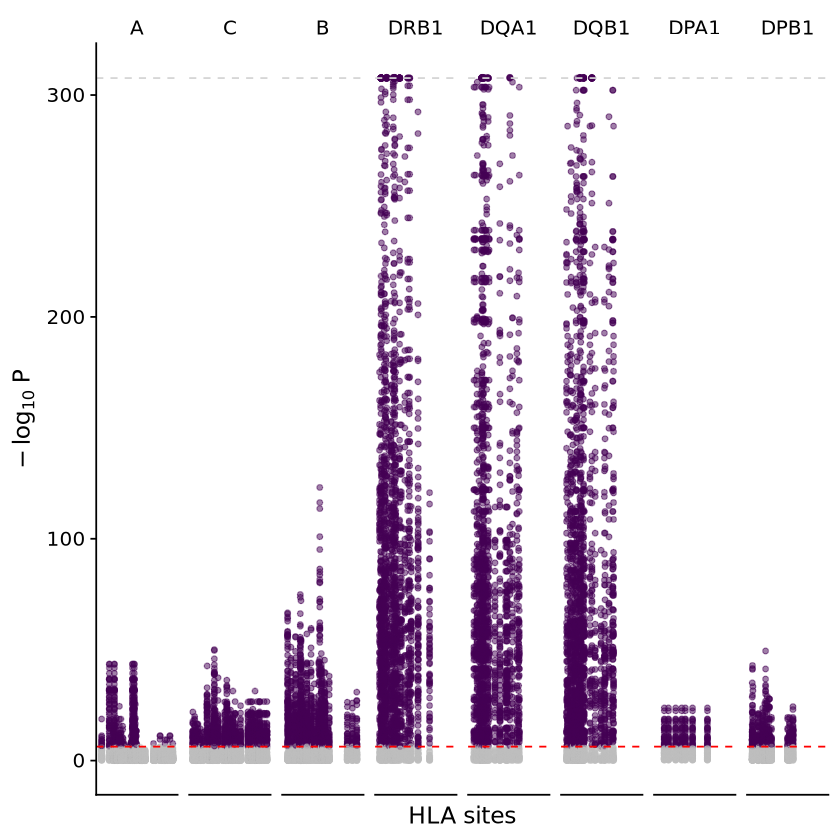

In [5]:
hla_genes = c('A','C','B','DRB1','DQA1', 'DQB1', 'DPA1','DPB1')
smallest_number <- .Machine$double.xmin
manova_3pcs <- na.omit(fread('../manova_results_3PCs.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>%
    mutate(Site_hla = as.integer(Site_hla), Pr..F. = ifelse(Pr..F. == 0, smallest_number, Pr..F.)) %>%
    rename(Pvalue = Pr..F.)
bonf <- 0.01/nrow(manova_3pcs)


pl_ours <- ggplot(manova_3pcs) +
    geom_point(aes(x = Site_hla, y = -log10(Pvalue), color = ifelse(Pvalue < bonf, 'significant', ' ')), alpha=0.5, size=1.3, show.legend = FALSE) +
    scale_color_manual(values = c('significant' = '#440154', ' ' = 'grey')) +
    #scale_x_discrete(breaks = as.integer(seq(0,300, length.out = 5))) +
    labs(x = "HLA sites", y = expression(paste(-log[10], " ", P))) +
    geom_hline(yintercept= - log10(bonf), linetype="dashed", color = "red") +
    geom_hline(yintercept= - log10(smallest_number), linetype="dashed", color = "lightgrey") +
    theme(legend.position = "none") +
    theme_cowplot() +
    facet_grid(~factor(HLA, levels = hla_genes), space = "free") +
    theme(axis.text.x = element_blank(), strip.background = element_rect(fill = "white"),  
          axis.ticks.x=element_blank()) 
    #geom_segment(data = hla_annotation, aes(x = start, xend = end, y=-0.01, yend=-0.01), color = 'blue', label = NA)
pl_ours
#ggsave('../plots/3Pcs_manova_plot.jpg',pl, width = 10, height = 4)

Saving 6.67 x 6.67 in image



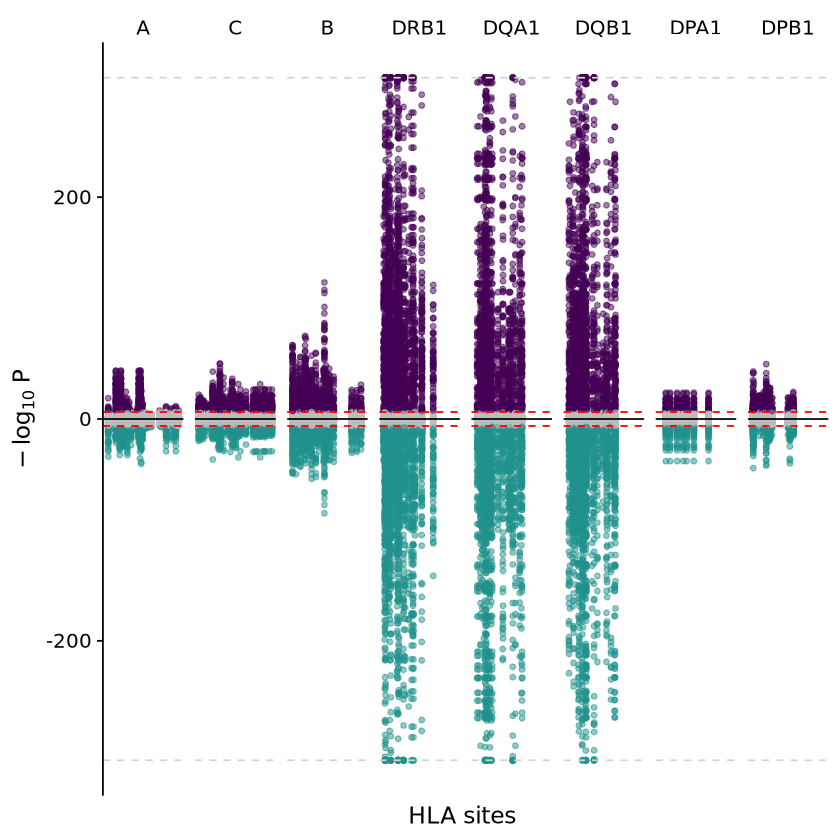

In [9]:
plots_both_one_axis <- ggplot() +
    geom_point(data = manova_3pcs, aes(x = Site_hla, y = -log10(Pvalue), color = ifelse(Pvalue < bonf, 'significant', ' ')), 
               alpha=0.5, size=1.3, show.legend = FALSE) +
    scale_color_manual(values = c('significant' = '#440154', ' ' = 'grey')) +
    new_scale_color() +
    geom_point(data = manova_9pcs, aes(x = Site_hla, y = log10(Pvalue), color=ifelse(Pvalue < (0.01/24360), 'significant', ' ')), 
               alpha=0.5, size=1.3, show.legend = FALSE) +
    scale_color_manual(values = c('significant' = '#21918c', ' ' = 'grey')) +
    #scale_x_discrete(breaks = as.integer(seq(0,300, length.out = 5))) +
    labs(x = "HLA sites ", y = expression(paste(-log[10], " ", P))) +
    geom_hline(yintercept=  -log10(bonf), linetype="dashed", color = "red") +
    geom_hline(yintercept=  -log10(smallest_number), linetype="dashed", color = "lightgrey") +
    geom_hline(yintercept=  log10(smallest_number), linetype="dashed", color = "lightgrey") +
    geom_hline(yintercept= 0, linetype="solid", color = "black") +
    geom_hline(yintercept= log10(bonf), linetype="dashed", color = "red") +
    theme(legend.position = "none") +
    theme_cowplot() +
    facet_grid(~factor(HLA,levels = hla_genes), space = "free") +
    theme(axis.text.x = element_blank(), strip.background = element_rect(fill = "white"), axis.line.x = element_blank(),  
          axis.ticks.x = element_blank())
plots_both_one_axis
ggsave('../plots//miami_3_9pcs.jpg', plots_both_one_axis)

In [230]:
their_uniuqe_sites <- both_datasets %>% 
    group_by(HLA, Site_hla) %>% 
    mutate(Novel = uniqueN(Dataset)) %>% 
    filter(Site_hla > 0 , Novel == 1) %>% 
    dplyr::select(HLA, Site_hla) %>% unique()

In [254]:
their_uniuqe_sites %>% arrange(HLA, Site_hla)

HLA,Site_hla
<chr>,<int>
A,12
A,17
A,56
A,73
A,109
A,245
A,283
A,297
B,30


In [211]:
search_sites <- paste0(paste(their_uniuqe_sites$HLA, their_uniuqe_sites$Site_hla, sep = '_'), '_')

In [212]:
search_sites 

[1] "DQB1_56_"  "DQB1_135_" "DRB1_189_" "DRB1_166_" "DRB1_231_" "DRB1_40_" 
 [7] "DRB1_38_"  "DQB1_130_" "C_193_"    "DRB1_85_"  "B_62_"     "B_158_"   
[13] "DQB1_126_" "B_65_"     "A_73_"     "A_245_"    "B_145_"    "A_17_"    
[19] "DRB1_112_" "DPA1_11_"  "DPB1_33_"  "DPB1_205_" "A_56_"     "C_113_"   
[25] "A_109_"    "A_297_"    "C_143_"    "C_170_"    "C_270_"    "C_284_"   
[31] "C_289_"    "C_291_"    "C_308_"    "C_309_"    "B_30_"     "A_12_"    
[37] "B_109_"    "A_283_"    "C_248_"    "C_6_"

In [213]:
grep(paste0(search_sites, collapse = '|'), list.files('../hla_matrices/all_variable_sites/'), value = TRUE)

character(0)

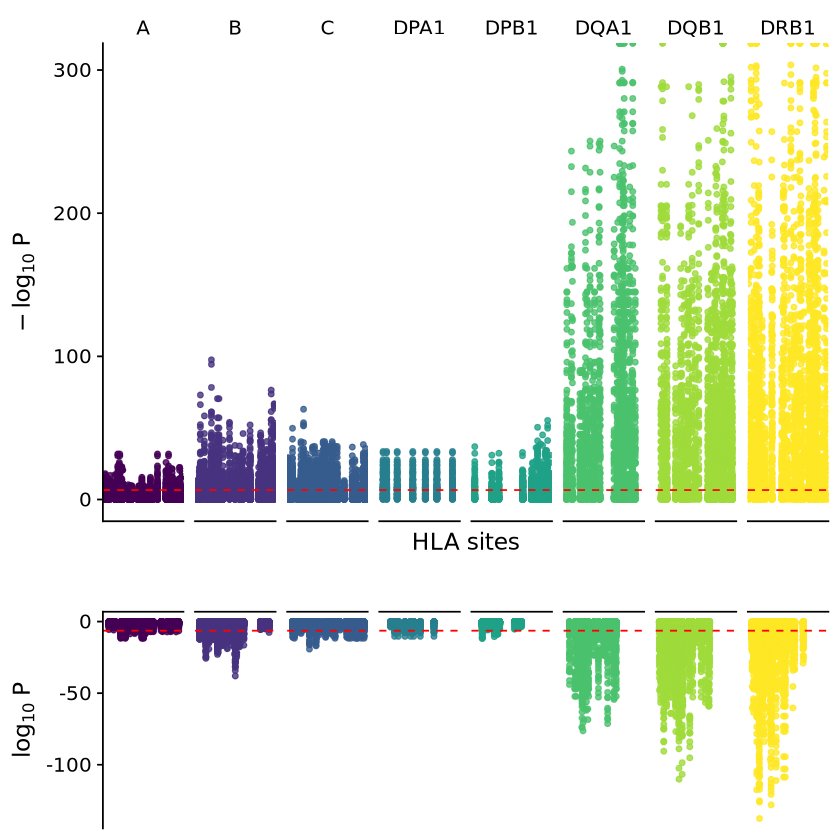

In [24]:
library(grid)
grid.newpage()
grid.draw(rbind(ggplot2::ggplotGrob(pl_ours), ggplot2::ggplotGrob(pl), size = "last"))


Saving 6.67 x 6.67 in image


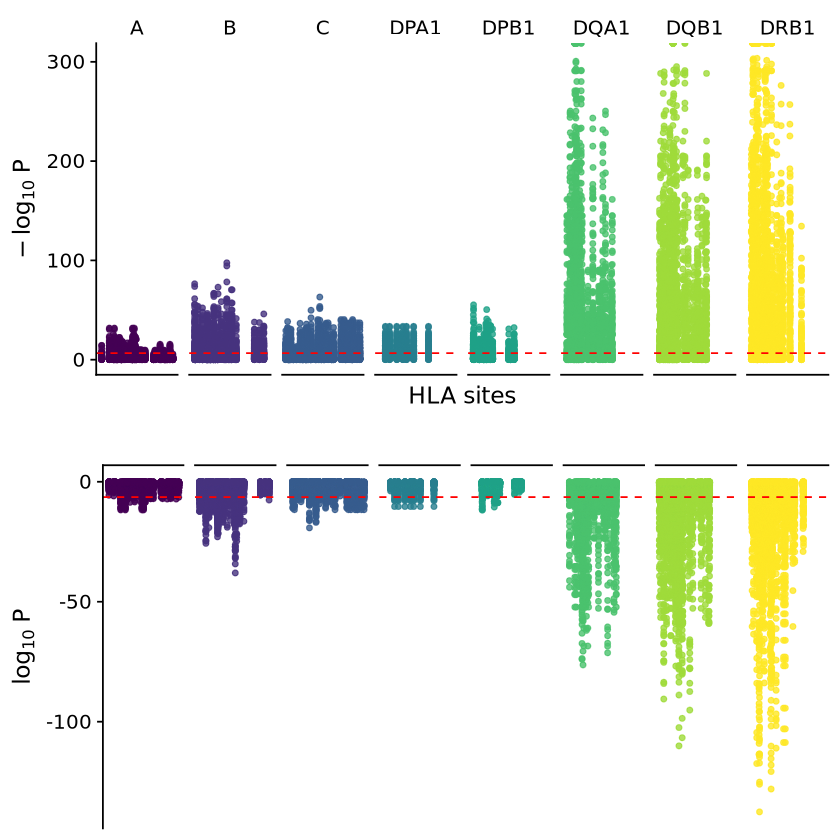

In [48]:
plots_both <- grid.arrange(pl_ours, pl)
ggsave('../plots//manhattan_plots_both.jpg', plots_both)

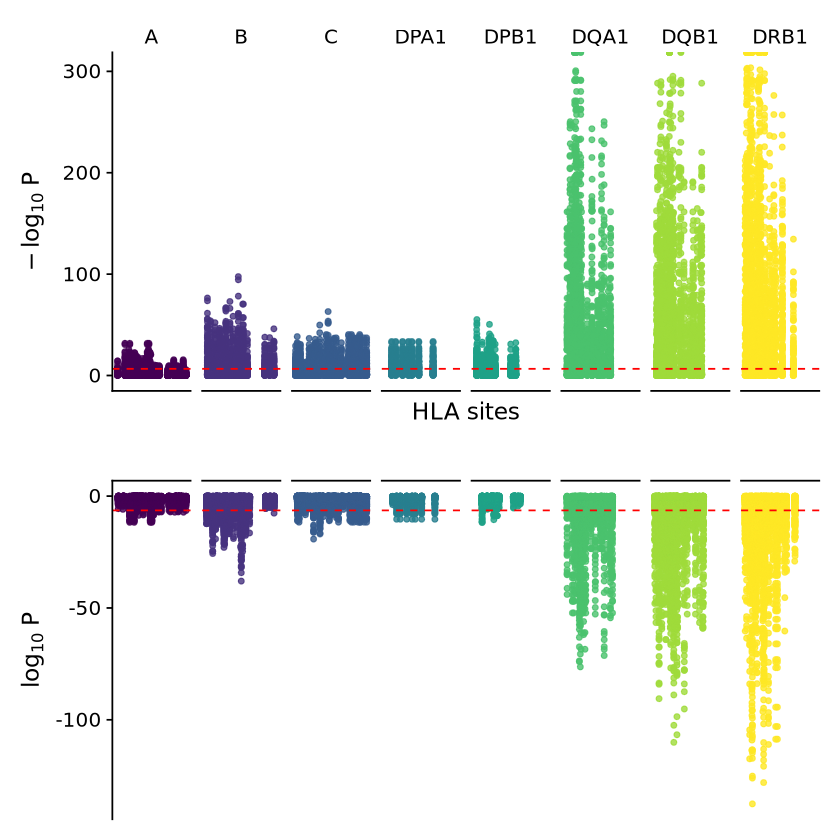

In [49]:
wrap_plots(pl_ours, pl, nrow = 2)

Saving 6.67 x 6.67 in image



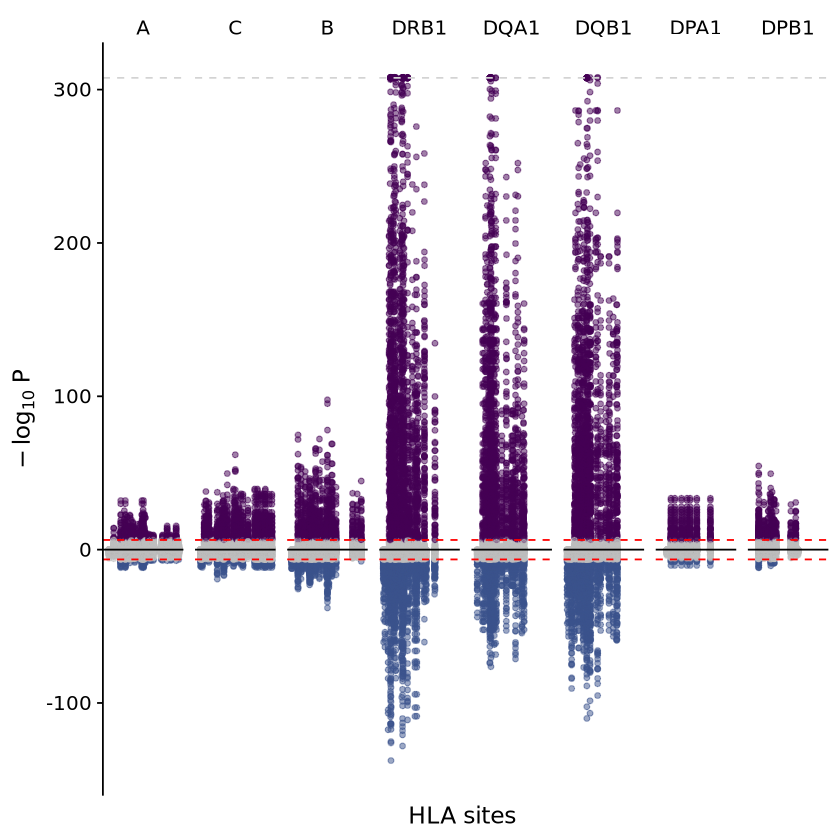

In [34]:
our_manova <- na.omit(fread('../HEALTHY/manova_results_wo_correlation_in_PCA.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>%
    mutate(Site_hla = as.integer(Site_hla))

### UpSet plots with intersection of independent sites between analyses for each gene

In [ ]:
manova_files <- list.files(path = dir_analysis, pattern = "*.tsv", full.names = TRUE)
manova_df_all <- rbindlist(lapply(file_list, fread))
fwrite(manova_df_all, paste0(dir_analysis, 'manova_all.tsv'), sep = '\t')

In [3]:
source('libraries.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract


Registered S3 methods overwritten by 'ggtern':
  method           from   
  grid.draw.ggplot ggplot2
  plot.ggplot      ggplot2
  print.ggplot     ggplot2

--
Remember to cite, run citation(package = 'ggtern') for further info.
--


Attaching package: ‘ggtern’


The following objects are masked from ‘package:ggplot2’:

    aes, annotate, ggplot, ggplot_build, ggplot_gtable, ggplotGrob,
    ggsave, layer_data, theme_bw, theme_classic, theme_dark,
    theme_gray, theme_light, theme_linedraw, theme_minimal, theme_void


Loading required package: viridisLite


Attaching package: ‘purrr’


The following obje

In [29]:
path_plot_out <- '../plots/dots_across_all_with_lengths_updated_december_colored.jpg'
source('Intersections_plot.R')

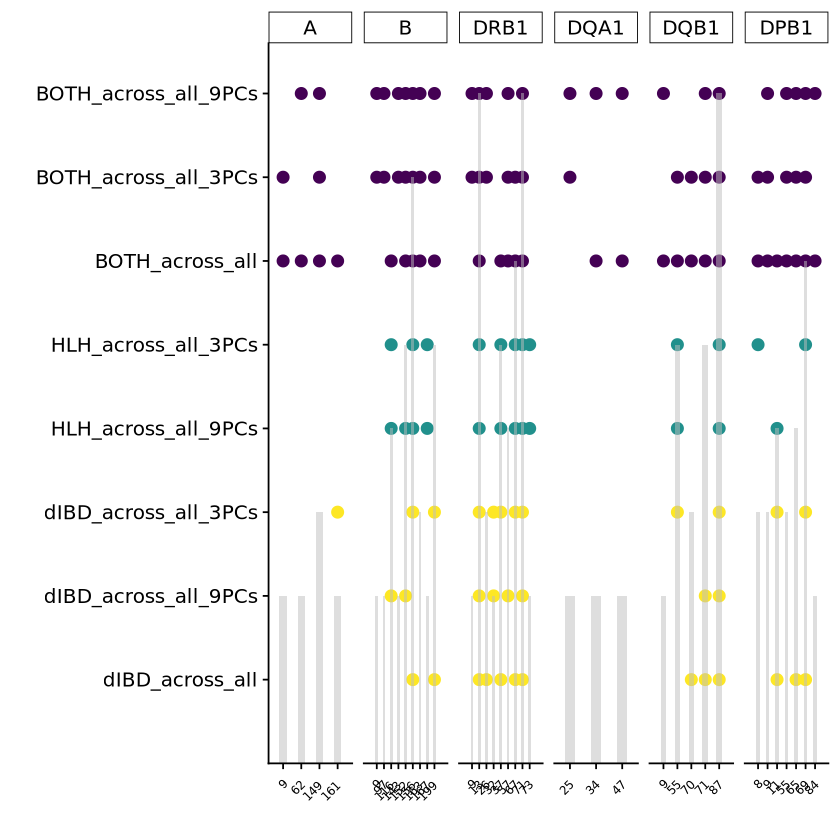

In [30]:
dots

### Associations with CDR3 amino acids for those HLA sites

In [44]:
sites_patterns_search <- apply(intersection_df_all %>% dplyr::select(gene, value) %>% mutate(value = paste0(value)), 1, 
      function(x) paste0(paste0(x, collapse = '_'), '_'))

In [146]:
path_to_look <- '../cdr3_hla_pairs/irt_freq_unique/'
files_in_path <- paste0(path_to_look, list.files(path_to_look))
cdr3_lengths <-c('12', '13', '14', '15', '16')

In [206]:
hla_sites_length <- paste0(apply(expand.grid(sites_patterns_search, cdr3_lengths), 1, paste, collapse=''), '_')

In [ ]:
pairs_to_plot <- grep(paste(hla_sites_length, collapse = '|'), files_in_path, value = TRUE)
for (f in pairs_to_plot){
    cdr3_hla_matrix <- fread(f)
    alleles <- colnames(cdr3_hla_matrix %>% dplyr::select(contains('allele')))
    amino_acids <-c('A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y') 
    cdr3_hla <- cdr3_hla_matrix %>% dplyr::select(patient_id, any_of(alleles), any_of(amino_acids))
    cdr3_hla_long <- cdr3_hla %>% pivot_longer(!c(patient_id, any_of(alleles)), names_to = "AA", values_to = "IRT_freq") %>% 
        pivot_longer(contains('allele'), names_to = 'allele', values_to = 'allele_dosage')
    parts <- unlist(strsplit(gsub('.tsv','', unlist(strsplit(f, '/'))[4]), '_'))
    var_names <- c('gene', 'site', 'cdr3_len', 'imgt')
    names(parts) <- var_names
    cdr3_hla_plot <- ggplot(cdr3_hla_long, aes(x = allele_dosage, y = IRT_freq, color = allele)) +
        geom_point(alpha = 0.1) + 
        scale_color_viridis_d() +
        scale_x_continuous(breaks = c(0,1,2)) + 
        theme_cowplot()+
        stat_smooth(method = "lm", formula = 'y ~ x', color = '#9f2a63') + 
        facet_wrap_paginate(~ allele + AA, nrow = length(alleles), strip.position = 'top') +
        labs( x = paste('Allele dosages for',parts[['gene']], 'site', parts[['site']]), 
             y = paste('AA frequencies at CDR3 position',parts[['imgt']],' (length',parts[['cdr3_len']],', w/o expansion)')) +
        theme(axis.text.x = element_text(size = 8, hjust = 1),
            axis.text.y = element_text(size = 8))
    cdr3_hla_plot
    plot_path <- paste0('../plots/associations_significant_sites/',paste0(parts, collapse = '_'), '.png')
    ggsave(plot_path, cdr3_hla_plot, width = 20, height = 10, dpi = 300)  
}


### Another drafts for dotplot

In [92]:
data_list <- split(expanded_hla_df_all, expanded_hla_df_all$gene)

# Create individual plots
plot_list <- lapply(data_list, function(data) {
    ggplot()+
    geom_dotplot(data = data, 
                 aes(x = factor(value), y = factor(L1, levels = names(hla_gene)), fill = status), 
                 show.legend = FALSE, stackdir = 'center', dotsize = 2.5) + 
    scale_fill_manual(values = c('yes' = 'black', 'no' = 'white')) +
    theme_cowplot()  + 
    labs(y = ' ', x = paste0('HLA-',unique(data$gene),' sites')) +
    theme(axis.text.x = element_text(angle = 45, hjust = 0.5, size = 10, margin = margin(t = 15)),
         strip.background = element_rect(fill = "white"))
})


data_bars <- split(intersection_df_all, intersection_df_all$gene)

# Create individual plots
plot_list_bars <- lapply(data_bars, function(data_bar) {
    ggplot(data = data_bar)+
    geom_col(aes(y = intersections, x = factor(value)), width = 0.2) +
    geom_text(data = data_bar, 
              aes(x = factor(value), y = intersections, label = ifelse(intersections>1, intersections, '')), vjust = -0.5, size = 5) +
    theme_void() +
    ylim(0, max(data_bar$intersections)+0.5)
})



In [95]:
combined_plot <- (plot_list_bars[[1]] / plot_list[[1]]) | (plot_list_bars[[3]] / plot_list[[3]]) | (plot_list_bars[[2]] / plot_list[[2]]) + plot_layout(widths = c(1, 1.5, 1))

In [96]:
ggsave('../plots/dots_combined_plot.jpg', combined_plot, width = 10, height = 7)

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


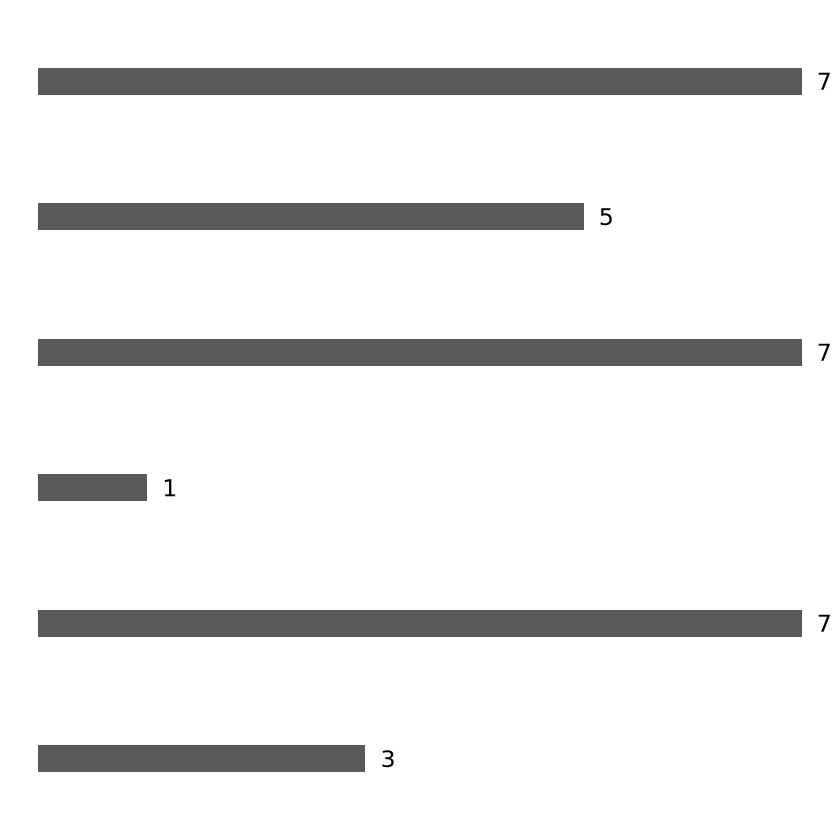

In [11]:
bars <- ggplot(set_sizes, aes(y = L1, x = number_sites)) + 
    geom_col(width = 0.2) +
    geom_text(aes(label = number_sites), hjust = -1, size = 5) +
    theme_void()
bars    

In [12]:
dots_bars <- dots + bars

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


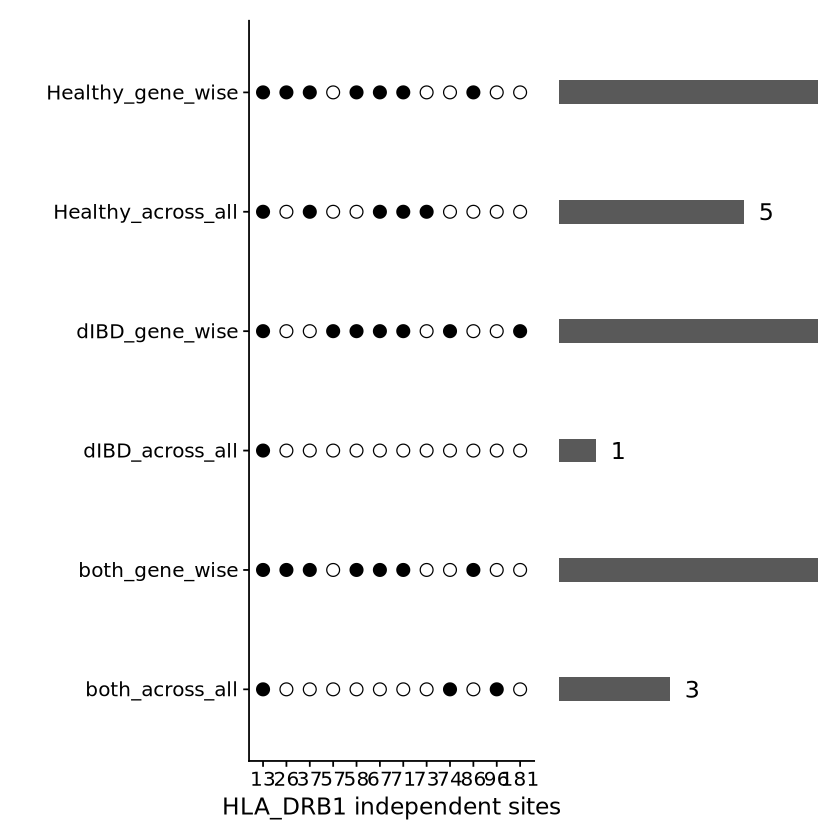

In [13]:
dots_bars

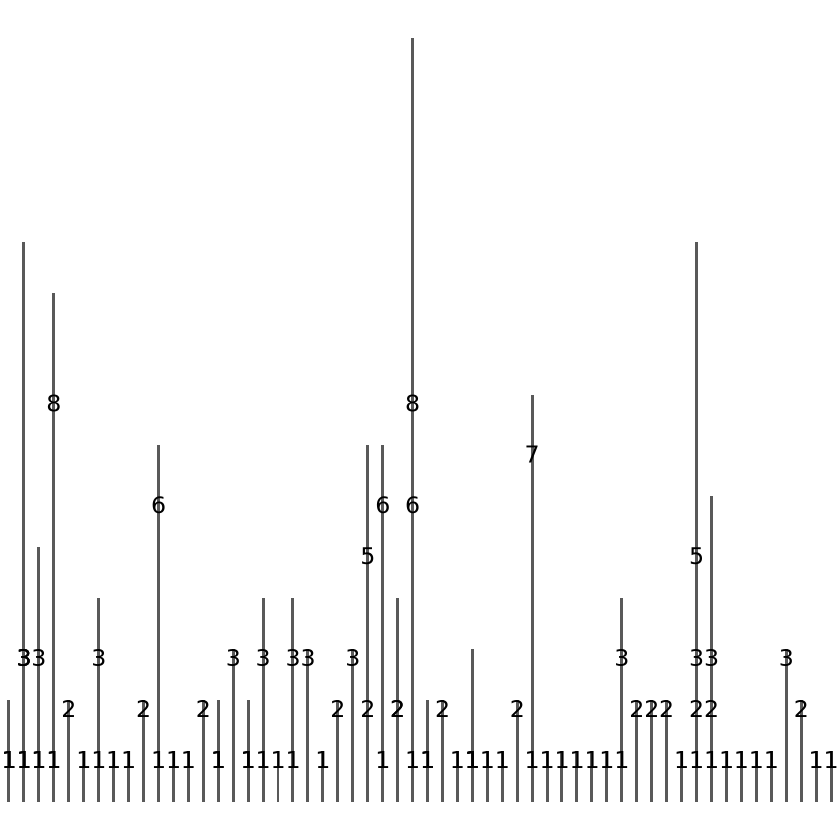

In [41]:
bars_2 <- ggplot(intersection_df_all, aes(y = intersections, x = factor(value))) + 
    geom_col(width = 0.2) +
    geom_text(aes(label = intersections), vjust = 1, size = 5) +
    theme_void()
bars_2

In [1]:
# Align the plots side by side
combined_plot <- (bars_2 + plot_spacer()) / dots_bars
combined_plot
#combined_plot + plot_layout(ncol = 2, widths = c(4, 1), heights = c(1, 4))

ERROR: Error in eval(expr, envir, enclos): object 'bars_2' not found


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


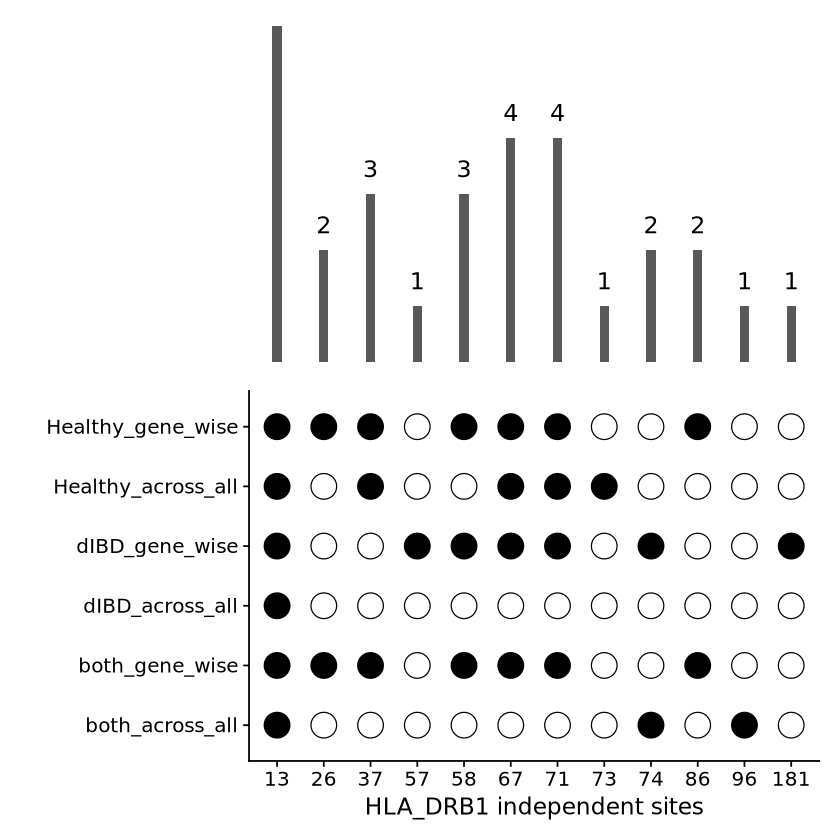

In [18]:
(bars_2 / dots)

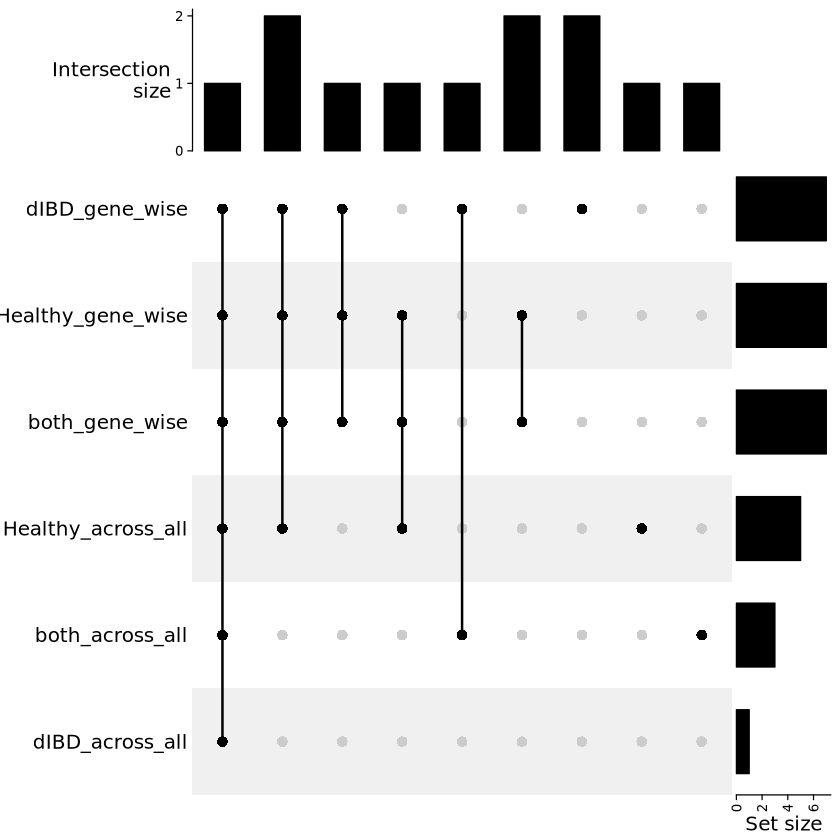

In [41]:
UpSet(hla_drb1_comb_mat)

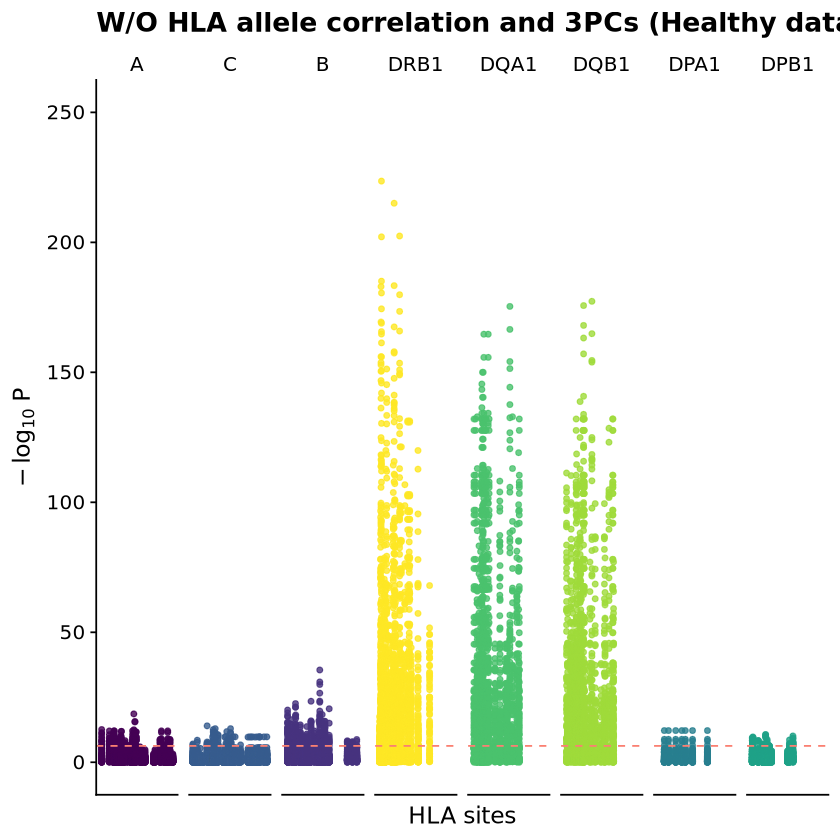

In [49]:
pl_ours <- ggplot() +
    geom_point(data = our_manova, aes(x = Site_hla, y = -log10(Pr..F.), color=as.factor(HLA)), alpha=0.8, size=1.3, show.legend = FALSE) +
    scale_color_viridis_d('inferno') +
    #scale_x_discrete(breaks = as.integer(seq(0,300, length.out = 5))) +
    labs(x = "HLA sites", y = expression(paste(-log[10], " ", P))) +
    geom_hline(yintercept= - log10(bonf), linetype="dashed", color = "salmon") +
    theme(legend.position = "none") +
    theme_cowplot() +
    facet_grid(~factor(HLA, levels = hla_genes), space = "free") +
    theme(axis.text.x = element_blank(), strip.background = element_rect(fill = "white"),  
          axis.ticks.x=element_blank()) +
    ggtitle('W/O HLA allele correlation and 3PCs (Healthy dataset)') +
    ylim(0,250)
    #geom_segment(data = hla_annotation, aes(x = start, xend = end, y=-0.01, yend=-0.01), color = 'blue', label = NA)
pl_ours
ggsave('../plots/manhattan_plot_wo_correlation_alleles_3PCs.jpg',pl_ours, width = 10, height = 4)


In [98]:
expanded_hla_df_all_with_intersections <- expanded_hla_df_all %>% 
    group_by(gene, value) %>% 
    mutate(intersections = sum(status == "yes")) %>% ungroup()

### Visualise PERMANOVA as probability of influence

In [10]:
conn

<SQLiteConnection>
  Path: /work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/permanova_results/PERMANOVA_999perm.db
  Extensions: TRUE

In [13]:
library(RSQLite)
conn <- dbConnect(RSQLite::SQLite(), dbname = '/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/permanova_results/PERMANOVA_999perm.db')
permanova_results <- tbl(conn, '/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/permanova_results/PERMANOVA_999perm.db')

In [92]:
permanova_sig_hits <- permanova_results %>% collect() %>% unique() %>% filter(model == 'full', aic >=2) %>%
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'IMGT'), remove = FALSE) %>% 
    rename(Pvalue = `Pr(>F)`) %>% 
    group_by(HLA, Site_hla) %>%
    filter(Pvalue == min(Pvalue)) %>% 
    filter(var_exp == max(var_exp)) %>% arrange(HLA, Site_hla) %>% mutate(Site_hla = as.integer(Site_hla))

Warning message:
“Expected 4 pieces. Additional pieces discarded in 383 rows [5, 7, 16, 18, 23, 24, 31, 33, 34, 38, 39, 45, 46, 57, 67, 72, 73, 76, 82, 89, ...].”


In [93]:
head(permanova_sig_hits)

Df,SumOfSqs,R2,F,Pvalue,model,pair,HLA,Site_hla,Length_cdr3,IMGT,var_exp,aic
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>
3,51.79482,0.011428733,7.391243,0.001,full,A_105_17_P111.1,A,105,17,P111,0.003012623,3.839942
3,52.29647,0.008978919,5.792533,0.001,full,A_107_18_P111.1,A,107,18,P111,0.003414361,4.602126
4,13.49021,0.009726831,4.707372,0.001,full,A_114_14_P113,A,114,14,P113,0.003225906,2.232115
3,28.67602,0.013091516,8.480870,0.001,full,A_116_17_P110,A,116,17,P110,0.003217073,4.246693
3,28.69664,0.013100931,8.487050,0.001,full,A_127_17_P110,A,127,17,P110,0.003226488,4.265029
3,51.47032,0.008837075,5.700210,0.001,full,A_142_18_P111.1,A,142,18,P111,0.003272518,4.327052


Saving 6.67 x 6.67 in image



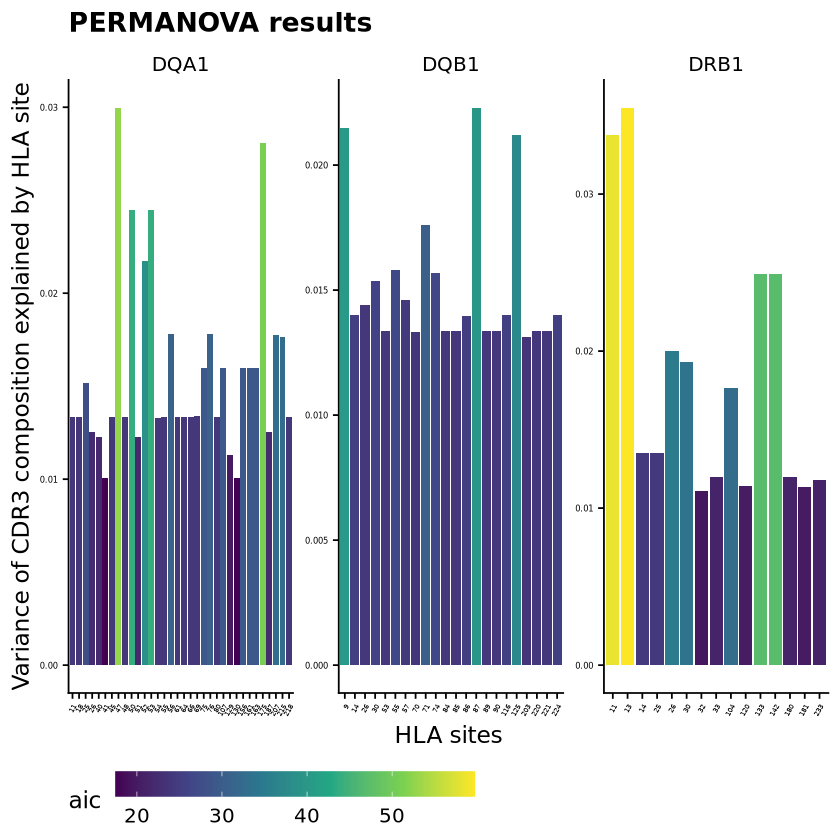

In [104]:
pl <- ggplot(permanova_sig_hits %>% filter(HLA %in% c('DRB1', 'DQB1', 'DQA1')) %>% filter(var_exp > 0.01), aes(x = as.factor(Site_hla), y = var_exp, fill = aic)) +
    geom_col() +
    scale_fill_viridis_c() +
    facet_wrap(~ HLA, scales = 'free') +
    theme_cowplot() +
    theme(legend.position = 'bottom',  
        axis.text.x = element_text(size = 4, angle = 60, hjust = 1),
        axis.text.y = element_text(size = 5),
        strip.background = element_rect(fill = "white")) +
    labs(title = 'PERMANOVA results', x = 'HLA sites', y = 'Variance of CDR3 composition explained by HLA site') +
    guides(fill=guide_colourbar(barwidth=15))
pl
ggsave('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/permanova_res.png', pl)